In [61]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [62]:
df = pd.read_csv('twitter_human_bots_dataset.csv')
print(f"Shape: {df.shape}")
print(f"Account types: {df['account_type'].value_counts()}")
df

Shape: (37438, 20)
Account types: account_type
human    25013
bot      12425
Name: count, dtype: int64


,Unnamed: 0,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,profile_background_image_url,profile_image_url,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,0,2016-10-15 21:32:11,False,False,"Blame @xaiax, Inspired by @MakingInvisible, us...",4,1589,4,False,787405734442958848,en,unknown,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/7874121826...,best_in_dumbest,11041,False,7.870,1403,bot
1,1,2016-11-09 05:01:30,False,False,Photographing the American West since 1980. I ...,536,860,880,False,796216118331310080,en,Estados Unidos,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8023296328...,CJRubinPhoto,252,False,0.183,1379,human
2,2,2017-06-17 05:34:27,False,False,Scruffy looking nerf herder and @twitch broadc...,3307,172,594,True,875949740503859204,en,"Los Angeles, CA",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1278890453...,SVGEGENT,1001,False,0.864,1159,human
3,3,2016-07-21 13:32:25,True,False,Wife.Godmother.Friend.Feline Fanatic! Assistan...,8433,517,633,True,756119643622735875,en,"Birmingham, AL",NaN,http://pbs.twimg.com/profile_images/1284884924...,TinkerVHELPK5,1324,False,0.889,1489,human
4,4,2012-01-15 16:32:35,False,False,Loan coach at @mancity & Aspiring DJ,88,753678,116,True,464781334,en,"England, United Kingdom",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9952566258...,JoleonLescott,4202,True,1.339,3138,human
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37433,37433,2009-08-08 13:11:15,True,False,"Role: Stock Taker. Past Roles: Nanny, Sales As...",651,139,1105,False,63963107,en,Kingston Upon Hull,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/5844684414...,butchsekab,340,False,0.084,4028,human
37434,37434,2013-01-05 21:35:37,False,False,KINGDOM LANDLORD #FreeCornBread,8839,1121486,605,True,1064042478,en,unknown,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9511349456...,Mathieu_Era,24970,True,8.976,2782,human
37435,37435,2013-01-14 18:05:54,True,False,Bienvenid@s al Twitter Oficial de Sergio Dalma...,399,85630,190,False,1089732602,it,En constante movimiento,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1174733822...,SDalmaoficial,6174,True,2.226,2773,human
37436,37436,2012-09-10 16:12:02,False,False,Just a good guy wrapped up in a bad system.\r\...,967,138,166,True,815529979,en,"Los Angeles, CA",http://abs.twimg.com/images/themes/theme14/bg.gif,http://pbs.twimg.com/profile_images/1265807908...,VinceYearly,982,False,0.339,2899,human


In [63]:
df = df.drop_duplicates(subset=['id'], keep='first')

numericals = ['favourites_count', 'followers_count', 'friends_count', 'statuses_count', 'average_tweets_per_day', 'account_age_days']
nulls = df[numericals].isnull().sum()
df[numericals] = df[numericals].fillna(0)

text_cols = ['description', 'location', 'screen_name']
nulls = df[text_cols].isnull().sum()
print(nulls)
df['description'] = df['description'].fillna("")
df['location'] = df['location'].fillna('unknown')
bool_cols = ['geo_enabled', 'verified', 'default_profile', 'default_profile_image']
for col in bool_cols:
    df[col] = df[col].astype(int)

description    7257
location          4
screen_name       0
dtype: int64


In [64]:
drop_cols = ['profile_background_image_url', 'profile_image_url', 'created_at']
df = df.drop(columns=drop_cols)

In [65]:
from sklearn.decomposition import TruncatedSVD
tfidf = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_mat = tfidf.fit_transform(df['description'])
num_topic = 10
svd = TruncatedSVD(n_components=num_topic, random_state=42)
svd_matrix = svd.fit_transform(tfidf_mat)
svd_df = pd.DataFrame(
    svd_matrix, 
    columns=[f"topic_{i}" for i in range(num_topic)]
)

df_final = pd.concat([df.reset_index(drop=True), svd_df.reset_index(drop=True)], axis=1)

print(f"Added {num_topic} text component features.")
print(df_final.shape)


Added 10 text component features.
(37438, 27)


/Users/trpatil/Projects/Cpp_Code/env/lib/python3.9/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/trpatil/Projects/Cpp_Code/env/lib/python3.9/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/trpatil/Projects/Cpp_Code/env/lib/python3.9/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


In [66]:
exclude_cols = ['description', 'location', 'account_type', 'id', 'screen_name', 'lang']
feature_cols = [col for col in df_final.columns if col not in exclude_cols]

X = df_final[feature_cols].select_dtypes(include=[np.number]).values
y = df_final['account_type'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Features shape: {X.shape}")
print(f"Target distribution: {pd.Series(y).value_counts()}")
print(f"Encoded labels: {label_encoder.classes_}")


Features shape: (37438, 21)
Target distribution: human    25013
bot      12425
Name: count, dtype: int64
Encoded labels: ['bot' 'human']


In [67]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")


Train shape: (29950, 21)
Test shape: (7488, 21)


X_used shape: (37438, 21)


/Users/trpatil/Projects/Cpp_Code/env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/trpatil/Projects/Cpp_Code/env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/trpatil/Projects/Cpp_Code/env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/trpatil/Projects/Cpp_Code/env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/trpatil/Projects/Cpp_Code/env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/trpatil/Projects/Cpp_Code/env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/trpatil/Projects/Cpp_Code/env/lib/p

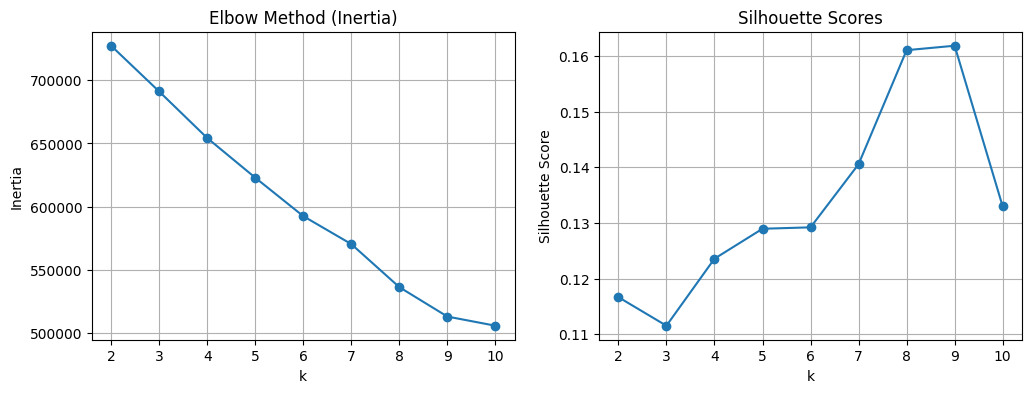

In [73]:
X_used = X_scaled.copy()
y_encoded_used = y_encoded.copy()  
print(f"X_used shape: {X_used.shape}")
X_used = X_used.astype(np.float64, copy=False)
abs_max = np.max(np.abs(X_used))
if not np.isfinite(abs_max) or abs_max > 1e8:
    X_used = np.clip(X_used, -1e8, 1e8)

ks = list(range(2, 11))
inertias = []
silScores = []
for k in ks:
    km = KMeans(n_clusters=k, n_init=10, init='random')
    labels = km.fit_predict(X_used)
    inertias.append(km.inertia_)
    try:
        sil = silhouette_score(X_used, labels) 
    except Exception as e: # Means too few clusters or something along those lines
        sil = np.nan
    silScores.append(sil)

# So for reference the methods of evaluating KMeans are based on inertia (elbow method) and silhouette scores
# The elbow method evaluates clusters based on the sum of the squared distances between each data point and the centroid of the cluster it belongs to
# Silhouette scores measure how similar a data point is to its own cluster compared to other clusters
# The two main components of silhouette scores are cohesion (how close data points are within the same cluster) and separation (how far apart different clusters are)
# With this, the final score is calculated as (separation - cohesion) / max(separation, cohesion)
# A score closer to +1 means that the data points are well clustered, while a score closer to -1 indicates that the data points may have been assigned to the wrong clusters
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(ks, inertias, '-o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method (Inertia)')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(ks, silScores, '-o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')
plt.grid(True)
plt.show()

# Pick best k by silhouette/elbow evaluation (described above)
sil_arr = np.array(silScores, dtype=float)
if np.all(np.isnan(sil_arr)):
    print("Too few clusters for silhouette score, defaulting to inertia eval")
    best_k = ks[int(np.argmin(inertias))]
else:
    best_k = ks[int(np.nanargmax(sil_arr))]


Best k= 9


/Users/trpatil/Projects/Cpp_Code/env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/trpatil/Projects/Cpp_Code/env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/trpatil/Projects/Cpp_Code/env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/trpatil/Projects/Cpp_Code/env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/trpatil/Projects/Cpp_Code/env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/trpatil/Projects/Cpp_Code/env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value enco

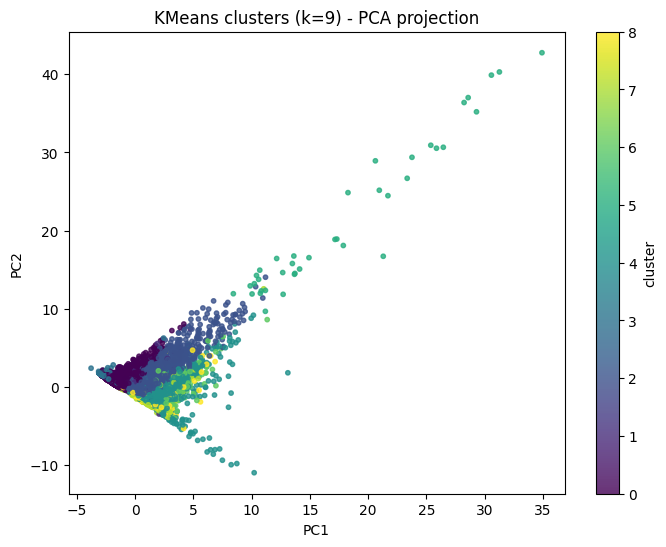

In [ ]:
best_k = ks[int(np.argmax(silScores))]
print(f'Best k= {best_k}')
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10) # NEED TO SET RANDOM STATE FOR ANALYSIS BELOW
df_final['kmeans_cluster'] = kmeans.fit_predict(X_used)

# PCA visualization of clusters
pca = PCA(n_components=2, random_state=42) # NEED TO SET RANDOM STATE !! 
proj = pca.fit_transform(X_used)
plt.figure(figsize=(8,6))
scatter = plt.scatter(proj[:,0], proj[:,1], c=df_final['kmeans_cluster'], s=10, alpha=0.8)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'KMeans clusters (k={best_k}) - PCA projection')
plt.colorbar(scatter, label='cluster')
plt.show()


In [98]:
# Cluster Summaries
print(df_final['kmeans_cluster'].value_counts())

kmeans_cluster
2    13908
0    13669
4     5912
6     1067
1      855
8      767
7      666
3      555
5       39
Name: count, dtype: int64


In [99]:
# Cluster x account type
display(pd.crosstab(df_final['kmeans_cluster'], df_final['account_type']))

account_type,bot,human
kmeans_cluster,,
0,7490,6179
1,220,635
2,3728,10180
3,381,174
4,255,5657
5,32,7
6,113,954
7,61,605
8,145,622


In [100]:
df_final.to_csv('df_final_with_clusters.csv', index=False)

In [79]:
# Cluster 0 is a bot majority cluster, with very few followers
# Cluster 1 contains a lot of descriptions containing the word "life"/related to life
# Cluster 2 is a human majority cluster without verified accounts
# Cluster 4 is also a human majority cluster with almost all strictly verified accounts (higher followers)
# Cluster 6 is another one with a higher number of humans(mixed verified status), but with a very high average followers count
# Cluster 8 contains a high number of accounts labeled as "official twitter" accounts in their description

In [ ]:
# Follower count in cluster 6
df_final[df_final["kmeans_cluster"] == 6]["followers_count"].mean()

np.float64(815305.0599812559)

In [ ]:
# Baseline follower count example
df_final[df_final["kmeans_cluster"] == 0]["followers_count"].mean()

np.float64(14121.164752359353)

In [ ]:
# Verified accounts for cluster 2
df_final[df_final["kmeans_cluster"] == 2]["verified"].mean()

np.float64(0.0001438021282714984)

In [ ]:
# Verified accounts for cluster 4
df_final[df_final["kmeans_cluster"] == 4]["verified"].mean()

np.float64(0.9993234100135318)

In [ ]:
# "Official" "Twitter" accounts
print(len(df_final[df_final["kmeans_cluster"] == 8][df_final["description"].str.contains("official", case=False, na=False)]),
len(df_final[df_final["kmeans_cluster"] == 8][df_final["description"].str.contains("twitter", case=False, na=False)]))

475 620


/var/folders/t7/ldh21q3x1rg6y_1y22thd7bc0000gn/T/ipykernel_88740/2151237951.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(df_final[df_final["kmeans_cluster"] == 8][df_final["description"].str.contains("official", case=False, na=False)]),
/var/folders/t7/ldh21q3x1rg6y_1y22thd7bc0000gn/T/ipykernel_88740/2151237951.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(df_final[df_final["kmeans_cluster"] == 8][df_final["description"].str.contains("twitter", case=False, na=False)]))
